## Lagrangian Hydrodynamics

<h3>INTRODUCTION</h3>
An inviscid fluid flow is described through the following conservation equations collectively known as the <b>Euler equations</b>.

Conservation of mass (continuity equation):
$$
\dot{\rho} + \nabla(\rho\,\mathbf{v}) = 0, \ \ \text{or} \ \ \ \ \left( \frac{\partial }{\partial t} + \mathbf{v} \nabla\right) \rho = - \rho \nabla\mathbf{v}
$$

Conservation of momentum: (Navier Stokes equation)
$$
\rho \left( \frac{\partial }{\partial t} + \mathbf{v} \cdot \nabla  \right) \mathbf{v}= -\nabla p + \rho \nu \nabla^2 \mathbf{v},
$$
where $\nu$ is the kinematic viscosity.

Conservation of energy: 
$$
\frac{\partial e}{\partial t} + \nabla\cdot(e\,\mathbf{v}) + p\nabla\cdot\mathbf{v} = 0
$$

In certain situations the pressure can sometimes be expressed as a function of $\rho$ only. Such as in the isothermal equation of state $p=c_0^2\,\rho$, where $c_0$ is the speed of sound. In this case the behavior is given only from the continuity equation and the momentum equation. Because $\nabla p=c_0^2 \nabla\rho$ and that is all we need for the momentum equation.

In this case for a Lagrangian description this boils down to solving this single equation:
$$
\frac{D\mathbf{v}}{Dt} = -\frac{1}{\rho}\nabla p
$$

So we have a second-order differential equation for the positions of our mass grid. 

So imagine we discretized the total mass $M$ with $N$ shells of mass, $\triangle m$ , with edges of $r_i$ with $0<i<N$ in the domain $[0,1]$. Call the initial pressure distribution at time zero $p_0$ and realize that the density, $\rho_i$ in our grid zones is always just simply given by $\rho_i = \triangle m/|r_{i+1}-r_{i}|$. So if we can describe our fluid purely with an equation of state described by $p = c_0^2\rho$ we only need to store the initial value of $c_0$ which may be a different in different parcels of the gas. 

We will first use a simple leap frog integrator to solve this. This operates in two parts. First we update the positions by half a time step $r_i = r_i + (dt/2)\,v_i$ then using these positions to calculate the accelerations 

\begin{equation}
-\frac{1}{\rho}\nabla p = - \frac{|r_{i+1}-r_i|}{\triangle m} 
 \nabla \left(\frac{\triangle m c_{0,i}^2}{|r_{i+1}-r_i|}\right)=-\frac{1}{\triangle m} \triangle r_i \nabla\frac{\triangle m c_{0,i}^2}{\triangle r_i},
\end{equation}
where $\triangle r_i = |r_{i+1}-r_i|$. Then we do the remaining part of the kick of the positions $r_i = r_i + (dt/2)\,v_i$. The two kicks can be combined one we keep them separate here so that at outputs we have positions and velocities at the same time. In the case where all shells have the same mass we could even eliminate $\triangle m$ in the accelerations. This may not in general be the case, however, so we keep it.
<p>
For the special case where pressure is only a function of density these are the only equations we would need. More generally we also have to consider an energy (or entropy) equation in order to account for the possibility that the internal energy could be different for different densities. However, in the Lagrangian case we know right away that the energy change is just the work done on the cell. I.e.
$$
\frac{Du}{dt} = - p \frac{dV}{dt},
$$ 
where $dV$ is the rate of change of the fluid element volume we are considering. 

<h3>Sound waves</h3>

Linearizing the continuity and momentum equation above for small perturbations $\rho_1$ and $v_1$ (i.e. assume $\rho = \rho_0 + \rho_1$ and $v = 0+v_1$) and differentiating the momentum equation one more time in time we can obtain the wave solutions with the linear dispersion relation $\omega=ck$
$$
v = v_{a} \exp[i(kx+\omega t)] = v_{a}\exp[ik(x + c t)] , \ \ \ \rho = \rho_0 \left(1-\frac{v_1}{c}\right).
$$
The mass coordinate is 
$$
m(x) = \int_0^1 \rho dx = \rho_0\left[x+\frac{v_a}{2\pi\,c_0}(\cos(2\pi\,x)-1)\right]
$$
so to set up a simple test we can choose equidistant points in mass and derive the positions by finding the roots of this last equation. 


25715  time steps to time:  16.900384016172453


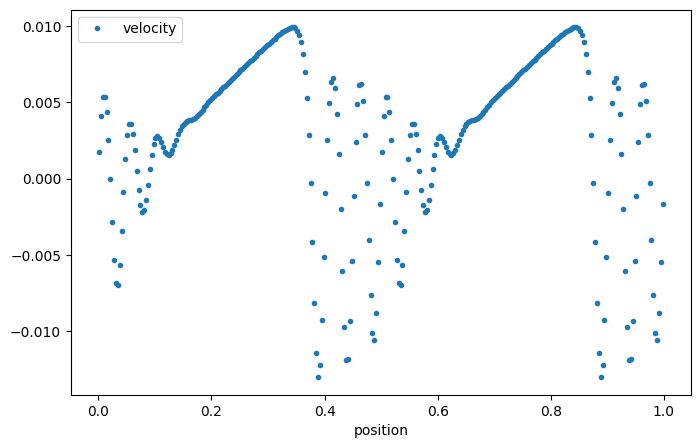

In [28]:

import numpy as np
import matplotlib.pyplot as plt
import time as systime
#from scitools.std import as sci
from scipy.optimize import brentq 

# Set default figure size to 10 inches wide by 6 inches tall
plt.rcParams['figure.figsize'] = [8, 5]

def accGradP(dr,m,c):
    rho = (m/np.fabs(dr))
    press = c**2 * rho
    return -1./rho * (press-np.roll(press,1))/(0.5*np.fabs(dr+np.roll(dr,1)))

N = 300
r = (0.+np.arange(N))/N
va = .01
rho0 = 1.
c = 1.
v = va*np.sin(4.*np.pi*r)
c0 = np.ones(N)
c0[:] = c
m = 1./N

mass = lambda x,off: rho0*(x+va/c*(np.cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r

    
Courantfactor = 0.2
dt = Courantfactor * 1./N

tfinal = 16.9
time = [0.]
vmax = [max(v)]
count=0
while (time[-1]<tfinal and count < 500000):
    r += dt/2 * v
    r[r>1] -= 1.
    r[r<0] += 1.
    dr = np.roll(r,-1)-r
    ind = np.where(np.fabs(dr)>0.5)
    dr[ind] = np.fabs(1.+dr[ind])
    acc = accGradP(dr,m,c0) 
    v += dt * acc
#    print accGradP(r,m,c0)
    r += dt/2 * v
    dt = Courantfactor*min(dr)/max((max(c0),max(v)))
    time.append((time[-1]+dt))
    count += 1
    vmax.append(max(v))
    
print(count, ' time steps to time: ', time[-1])
plt.plot(r,v,'.',label="velocity")
plt.xlabel("position")
plt.legend();

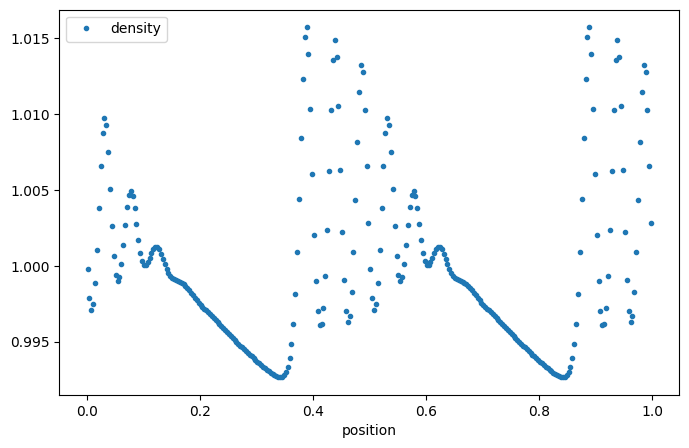

In [29]:
plt.plot(r,m/dr,'.',label="density");
plt.xlabel('position')
plt.legend();

<h4>Oh no!!!</h4>

Did we screw up our approach to solving the equations? 
What happened to our wave? 



## Wave steepening

Essentially all non-linear wave steepen! The ones that do not are arranged such that their dispersion just cancels the steepening. These are called <i>solitary wave</i> or <a href="http://en.wikipedia.org/wiki/Soliton" target="_blank"><i>solitons</i></a>. This is actually quite easy to understand. The sound speed of a gas is given by $c^2 = \partial p/\partial \rho$

<h3>Artificial Viscosity</h3>

<a href="http://jap.aip.org/resource/1/japiau/v21/i3/p232_s1">A Method for the Numerical Calculation of Hydrodynamic Shocks</a>
1950 by J. VonNeumann and R. D. Richtmyer layed out how to study shock waves by inroducing a so called artificial viscosity into the method. Let us explore this and see whether we can make it work. 

3041  time steps to time:  3.5000962670733284


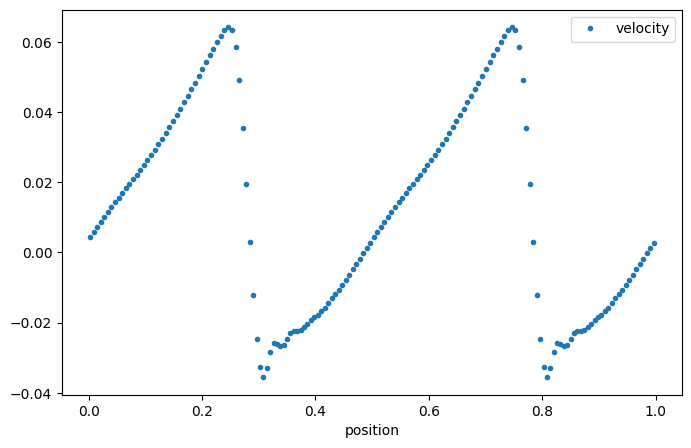

In [44]:
def accVisc(dr,m,v,dx_smear=.01):
    dv = (np.roll(v,-1)-v)/dr
    dif = -dx_smear**2 *dv*np.fabs(dv)  *(np.fabs(dr)/m)
    return -1./m*dr*(dif-np.roll(dif,1))/(0.5*np.fabs(dr+np.roll(dr,1)))

def accGradP(dr,m,c):
    dif = c**2* (m/np.fabs(dr))
    return -1./m*dr*(dif-np.roll(dif,1))/(0.5*np.fabs(dr+np.roll(dr,1)))

N = 160
r = (0.+np.arange(N))/N
xL = r+.5/N
va = .1
rho0 = 1.
c = 1.
v = va*np.sin(4.*np.pi*r)
c0 = np.ones(N)
c0[:] = c
m = 1./N

mass = lambda x,off: rho0*(x+va/c*(np.cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r

Courantfactor = 0.2
dt = Courantfactor * 1./N/max(v)

tfinal = 3.5
time = [0.]
vmax = [max(v)]
count=0
while (time[-1]<tfinal and count < 500000):
    r += dt/2 * v
    r[r>1] -= 1.
    r[r<0] += 1.
    dr = np.roll(r,-1)-r
    ind = np.where(np.fabs(dr)>0.5)
    dr[ind] = np.fabs(1.+dr[ind])
    acc = accGradP(dr,m,c0) + accVisc(dr,m,v,dx_smear=.02)
    v += dt * acc
#    print accGradP(r,m,c0)
    r += dt/2 * v
    dt = Courantfactor*min(dr)/max((max(c0),max(v)))

    time.append((time[-1]+dt))
    count += 1
    vmax.append(max(v))
    
print(count, ' time steps to time: ', time[-1])
plt.plot(r,v,'.',label="velocity")
plt.xlabel("position")
plt.legend();

In [ ]:
plot(r,accGradP(dr,m,c0), r, .01*accVisc(dr,m,v,dx_smear=.5));

Clean up the code a bit.

In [45]:
def diff(y):
    return y[1:]-y[0:-1]
def av(y):
    return (y[1:]+y[0:-1])/2
def eos_u(rho, p):
    u = p
    return u
    
class EquationOfState:
    def __init__(self, gammain):
        self.gamma = gammain
    def u(self,rho,p):
        return 1./(self.gamma-1.) * p/rho
    def cs(self,rho,p):
        return sqrt(self.gamma*p/rho)
    def p(self,rho,u):
        return (self.gamma-1)*rho*u

def VNR_q(dr,dm,v,kdx=.1):
    '''return VanNeumann Richtmyer viscosity'''
    dv = (v-np.roll(v,-1))/dr
    q = -kdx**2 *dv*fabs(dv)  *dr/dm
    return q

def accGradP(dr,m,p):
    rho = m/dr
    return -1./rho*(p-np.roll(p,1))/(0.5*fabs(dr+np.roll(dr,1)))

gasgamma = 1.001
eos = EquationOfState(gasgamma)

def LagrangeHydro(tfinal, r, v, dm, p):
    N = len(r)
    Courantfactor = 0.2
    dr = np.roll(r,-1)-r # cell volumes. 
    ind = where(fabs(dr)>0.5)
    dr[ind] = fabs(1.+dr[ind])
    drold = dr
    rho = dm/dr
    u = eos.u(rho, p)
    cs = eos.cs(rho,p)
    dt = Courantfactor * 1./N/max((max(cs), max(v)))
    kvnr = 4.
    dxvnr = 1./N

    count=0
    time = 0.
    while (time<tfinal and count < 500000):
        r += dt/2 * v
        dr = np.roll(r,-1)-r
        ind = where(fabs(dr)>0.5)
        dr[ind] = fabs(1.+dr[ind])
        q = VNR_q(dr,dm,v,kdx=kvnr*dxvnr)
        p = eos.p(dm/dr,u)
        
        acc = accGradP(dr,m,p+q) 
        v += dt * acc
    #    print accGradP(r,m,c0)
        r += dt/2 * v
        r[r>1] -= 1.
        r[r<0] += 1.

        dr = np.roll(r,-1)-r # cell volumes. 
        ind = where(fabs(dr)>0.5)
        dr[ind] = fabs(1.+dr[ind])
        
        dV = dr-drold
        u -= (p+q)*dV/dm
        rho = dm/dr
        p = eos.p(rho,u)
        
        drold = dr
        time += dt
        dt = Courantfactor*min(abs(dr))/(max(eos.cs(rho,p+q)+abs((v-np.roll(v,-1)) ))) # new time step

        count += 1
    return r, v, rho, p, u

In [46]:
N = 160
r = (0.+np.arange(N))/N
xL = r+.5/N
va = .1
rho0 = 1.
c = 1.
v = va*sin(4.*np.pi*r)
c0 = np.ones(N)
c0[:] = c
m = 1./N

mass = lambda x,off: rho0*(x+va/c*(cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r
ind = where(fabs(dr)>0.5)
dr[ind] = fabs(1.+dr[ind])

p = m/dr

r, v, den, p, u = LagrangeHydro(.1, r, v, m, p)

NameError: name 'sin' is not defined

In [47]:
import JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

def HydroMovie(solver, h=1.0, tfinal=2*2.0*np.pi, w0=1.0, phase=1.0):
    x, v, t = solver(tfinal, h, w0, phase)
    
    skiprate = int(len(t) / 100)
    skiprate = max(skiprate, 1)
    t = t[::skiprate]
    x = x[::skiprate]
    v = v[::skiprate]
    # create a simple animation
    fig = plt.figure()

    ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
    line, = ax.plot([], [], lw=2)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
        
    def init():
        line.set_data([], [])
        return line,
    
    def animate(i):
        line.set_data(x[:i], v[:i])
        return line,
    
    return animation.FuncAnimation(fig, animate, init_func=init,
                            frames=len(t), interval=60, blit=True)

ModuleNotFoundError: No module named 'JSAnimation'

In [49]:

mass = lambda x,off: rho0*(x+va/c*(np.cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r


<h3>Shock tube</h3>

Let us  study a problem where we have an experiment in which we have a tube with fixed ends. I.e. boundary conditions for the velocity will be $v(x=0)=v(x-1)=0$ in which we prepared the left half of the tube with gas of a certain pressure, and density, $p_l$ and $\rho_l$ separated from the the fluid on the right with $p_r$ and $\rho_l$ at $t=0$. You could imagine e.g. that we had a thin membrane to separate the two parts which we can remove very fast. 
<br>
To setup the interface we will use a smoothly varying function rather than an infinitesimal thin interface using the function $R(x)$ defined as
$$
R(x)\equiv \left[\tanh(x-x_0)/\triangle x+1\right]/2,
$$
which goes smoothly from 0 to 1 at $x_0$ over an interval of approximate width $\triangle x$.

value of ramp function dx from x0: 0.11920292202211763 
 integral of rampInt 0.5


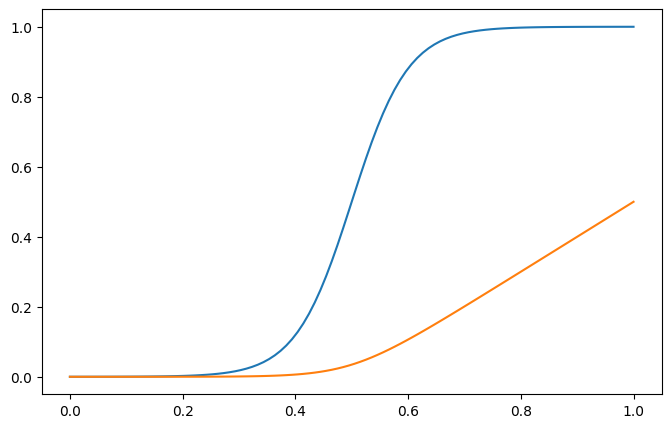

In [50]:
import matplotlib.pyplot as plt
import numpy as np
def ramp(x,x0,dx):
    '''ramp function. Goes from 0 to 1 smoothly at x0 over a transition region with width dx'''
    return (np.tanh((x-x0)/dx)+1.)/2
def rampInt(x,x0,dx):
    ''' integral from 0 to x of the ramp function ramp(x,x0,dx)'''
    return 0.5*(x + dx*np.log(np.cosh((x-x0)/dx)/np.cosh(x0/dx)))


x=np.linspace(0,1,100)
x0 =.5
dx = 0.1
plt.plot(x,ramp(x,x0,dx))
plt.plot(x,rampInt(x,x0,dx))
print("value of ramp function dx from x0:",ramp(x0-dx,x0,dx), \
    "\n integral of rampInt", rampInt(1.,x0,dx) )

So now we can describe e.g. the density as 
$$
\rho(x)=\rho_l+R(x)\,(\rho_r-\rho_l)
$$
and have as the integral 
$$
\int_0^x \rho(x') dx' = \rho_l\,x+(\rho_r-\rho_l) RI(x)
$$
where $RI(x)=\int_0^x R(x')dx'$.

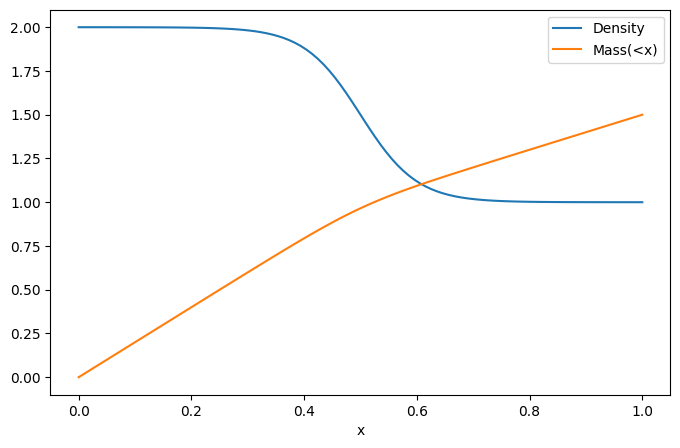

In [51]:
rhol=2
rhor=1
rho = rhol + ramp(x,x0,dx)*(rhor-rhol)
mass = rhol*x + (rhor-rhol)*rampInt(x,x0,dx)
plt.plot(x,rho,label="Density")
plt.plot(x,mass,label="Mass(<x)")
plt.xlabel("x")
plt.legend();

So now we have 
$$
\rho(x)=\rho_l+R(x)\,(\rho_r-\rho_l)
$$
$$
p(x)=p_l+R(x)\,(p_r-p_l)
$$
$$
v(x)=v_l+R(x)\,(v_r-v_l)

In [58]:
from scipy.optimize import brentq 

def diff(y):
    return y[1:]-y[0:-1]
def av(y):
    return (y[1:]+y[0:-1])/2
def eos_u(rho, p):
    u = p
    return u
    
class EquationOfState:
    def __init__(self, gammain):
        self.gamma = gammain
    def u(self,rho,p):
        return 1./(self.gamma-1) * p/rho
    def cs(self,rho,p):
        return np.sqrt(self.gamma*p/rho)
    def p(self,rho,u):
        return (self.gamma-1)*rho*u
    
    
## User Parameters
N = 1000
rhol = 1
rhor = 1
pl = 1000.
pr = 1
vl = 0
vr = 0
x0 = 0.5
dx = 1./N
kvnr = 4.
dxvnr = 1./N

gasgamma = 5./3
eos = EquationOfState(gasgamma)
## ===== done initial conditions specification

mass = lambda x,off: rhol*x + (rhor-rhol)*rampInt(x,x0,dx) - off
# now we discretize using equal mass bins
mt = np.linspace(0,1,N)*mass(1,0)
r = np.zeros(N)
for i in range(len(mt)):
    r[i] = brentq(mass,0,1,args=(mt[i]))  # cell faces containing mass mt[i]
ra = av(r) # cell centers

dr = diff(r)  # cell widths
dm = diff(mt) # mass of cell
rho = dm/dr
v = vl + ramp(r,x0,dx)*(vr-vl)  # velocities cell faces
p = pl + ramp(ra,x0,dx)*(pr-pl) # pressure at cell centers
u = eos.u(rho, p)

def VNR_q(dr,dm,v,kdx=.1):
    '''return VanNeumann Richtmyer viscosity'''
    dv = diff(v)/dr
    q = -kdx**2 *dv*np.fabs(dv)  *dr/dm
    return q

def accGradP(dr,dm,p):
    rho = dm/dr
    return np.concatenate(([0],-1./av(rho)*diff(p)/av(dr),[0]))


Courantfactor = .2
dt = Courantfactor * 1./np.max(eos.cs(rho,p))/N 

tfinal = 0.01  # try for time = 1, 2, 3 and 5 
time = [0.]
vmax = [max(v)]
count=0
edges = [0,-1]
v[edges] = 0
drold = diff(r)
states = []

while (time[-1]<tfinal and count < 100000):
    r += dt/2 * v
    dr = diff(r) # cell volumes. 
    q = VNR_q(dr,dm,v,kdx=kvnr*dxvnr)
    p = eos.p(dm/dr,u)
#    print min(q), max(q), median(q)
    acc = accGradP(dr,dm,p+q) # now accelerations and continue with leap frog step
    v += dt * acc
    r += dt/2 * v
    time.append((time[-1]+dt)) # remember times

    dr = diff(r) # cell volumes. 
    dV = dr-drold
    u -= (p+q)*dV/dm
    p = eos.p(rho,u)
    rho = dm/dr
    
    drold = dr
    dt = Courantfactor*min(abs(dr))/(max(eos.cs(rho,p+q)+abs(diff(v)) )) # new time step
    dt = min([dt, tfinal-time[-1]])  # do not integrate longer than asked to

    count += 1
    vmax.append(max(v))
    
    if ((count % 1) == 0):
        # Grab data at this step
        state_data = {
            "density"   : rho.copy(),
            "x_momentum": v.copy(),
            "pressure"  : p.copy(),
            "energy"    : u.copy(),
            "x"         : r.copy(),
            "step"      : count  # current step number
        }
        states.append(state_data)
    
    
#    print (((u)+av(v)**2/2)*dm).sum()

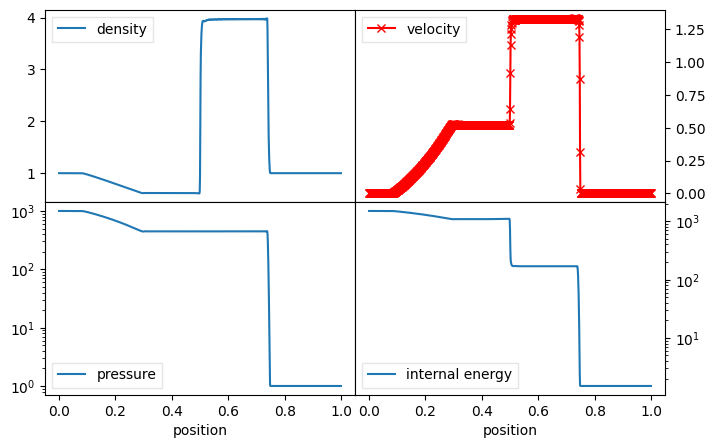

In [59]:
rhop = (gasgamma-1)/(gasgamma+1)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')
ax1.plot(ra, rho,label='density')

ax2.plot(ra, av(v)/eos.cs(rho,p),'rx-', label='velocity')
ax2.yaxis.tick_right()
ax3.semilogy(ra, p, label='pressure')
ax3.set_xlabel('position')
ax4.semilogy(ra, u, label='internal energy')
ax4.yaxis.tick_right()
ax4.set_xlabel('position')
for i in (ax1,ax2,ax3,ax4):
    leg = i.legend(loc='best', fancybox=False)
    leg.get_frame().set_alpha(0.5)

f.subplots_adjust(wspace=0,hspace=0)

In [60]:
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def shocktube_animation_app(states):
    """
    Create an interactive slider + play widget to browse precomputed 'states'.

    Parameters
    ----------
    states : list of dict
        Each element is a dictionary with keys:
         - "density", "x_momentum", "pressure", "energy" (arrays)
         - "x": the spatial coordinate array
         - "step": integer time step index

    Returns
    -------
    ui : widgets.VBox
        A VBox widget containing the slider, play controls, and the plot output.
    """
    # The total number of precomputed states
    ntotal = len(states)

    # 1) Create a slider to pick the index in [0, ntotal-1]
    slider = widgets.IntSlider(value=0, min=0, max=ntotal - 1, step=1,
        description='Step', continuous_update=False)

    # 2) Create a Play widget for auto animation
    play = widgets.Play(value=0, min=0, max=ntotal - 1,
        step=1,interval=200,       # ms between frames
        description="Press play", disabled=False)

    # Link the Play widget and the slider
    widgets.jslink((play, 'value'), (slider, 'value'))
    widgets.jslink((slider, 'value'), (play, 'value'))

    # 3) Create an output area for the Plotly figure
    output_area = widgets.Output()

    def update_plot(change=None):
        """Draw the figure for the current slider value."""
        index = slider.value
        state = states[index]

        with output_area:
            # Extract data
            x          = state["x"]
            step_num   = state["step"]

            # Build the figure
            fig = make_subplots( rows=2, cols=2,
                subplot_titles=["Density", "X-Momentum", "Pressure", "Energy"],
                vertical_spacing=0.09 )

            # 2x2 subplots
            fig.add_trace(go.Scatter(x=x, y=state["density"],    mode='lines+markers'), row=1, col=1)
            fig.add_trace(go.Scatter(x=x, y=state["x_momentum"], mode='lines+markers'), row=1, col=2)
            fig.add_trace(go.Scatter(x=x, y=state["pressure"],   mode='lines+markers'), row=2, col=1)
            fig.add_trace(go.Scatter(x=x, y=state["energy"],     mode='lines+markers'), row=2, col=2)
            fig.update_layout( title=f"Shocktube Data — Step {step_num}",
                showlegend=False, height=500, width=800,
                margin=dict(l=60, r=60, t=60, b=60) )

            # Show with "notebook" renderer so repeated calls don't stack new outputs
            output_area.clear_output(wait=True)
            fig.show("notebook")
            
    # 4) Observe slider changes => call update_plot
    slider.observe(update_plot, names='value')
    # 5) Initial figure
    update_plot()
    # 6) Combine play+slider+figure into a single UI
    controls = widgets.HBox([play, slider])
    ui = widgets.VBox([controls, output_area])

    return ui

In [61]:
shocktube_animation_app(states)